# 정확도 : 실제 데이터와 예측 데이터가 얼마나 같은지 판단하는 지표

#### 분류의 성능 평가 지표

* 정확도(Accuracy)
* 오차행렬(Confusion Matrix)
* 정밀도(Precision)
* 재현율(Recall)
* F1 스코어
* ROC AUC

분류는 결정 클래스 값 종류의 유형에 따라 긍정/부정과 같은 2개의 결과값만 가지는 이진 분류와 여러 개의 결정 클래스 값을 가지는 멀티 분류로 나뉠 수 있다.

# 정확도(Accuacy)

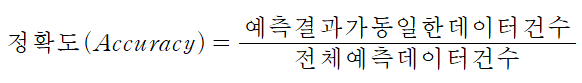

정확도는 직관적인 모델 예측 성능을 나타내는 평가 지표이다. 하지만 이진 분류의 경우 데이터의 구성에 따라 ML 모델의 성능을 왜곡할 수 있기 때문에 정확도 수치 하나만 가지고 성능을 평가하지 않는다. 

타이타닉 예제에서 여성의 생존률이 매우 높다. 그래서 특별한 알고리즘 없이 여성을 생존, 남성을 사망으로 분류해도 80% 정도 나올 수 있다.

In [1]:
# 사이킷런의 BaseEstimator 클래스를 상속받아 아무런 학습을 하지 않고, 성별에 따라 생존자 예측하는 Classifier
from sklearn.base import BaseEstimator
import numpy as np

class MyDummyClassifier(BaseEstimator):
    # fit() 메서드는 아무것도 학습하지 않음
    def fit(self, X, y=None):
        pass
    
    # predict() 메서드는 단순히 Sex 피처가 1이면 0, 0이면 1로 예측
    def predict(self, X):
        pred = np.zeros((X.shape[0], 1))
        for i in range(X.shape[0]):
            if X['Sex'].iloc[i] == 1:
                pred[i] = 0
            else:
                pred[i] = 1
        return pred

In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(),inplace=True)
    df['Cabin'].fillna('N',inplace=True)
    df['Embarked'].fillna('N',inplace=True)
    df['Fare'].fillna(0,inplace=True)
    return df

# 머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId','Name','Ticket'],axis=1,inplace=True)
    return df

# 레이블 인코딩 수행. 
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin','Sex','Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 앞에서 설정한 Data Preprocessing 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [3]:
# 예측 수행
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 원본 데이터 로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할
titanic_df = pd.read_csv('./titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=0)

myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)

mypredictions = myclf.predict(X_test)
print('Dummy Classifier의 정확도 : {0:.4f}'.format(accuracy_score(y_test, mypredictions)))

Dummy Classifier의 정확도 : 0.7877


이렇게 단순한 알고리즘으로 예측하더라도 데이터 구성에 따라 정확도가 78.77%로 꽤 높은 수치가 나왔다. 그렇기에 정확도를 평가 지표로 사용할 때는 매우 신중해야 한다.

특히 정확도는 불균형한(imbalanced) 레이블 값 분포에서 ML 모델의 성능을 판단할 경우, 적합한 평가 지표가 아니다.

예를 들어, 100개의 데이터가 있고 이 중 90개의 데이터 레이블이 0, 단 10개의 데이터 레이블이 1이라고 한다면 무조건 0으로 예측할 경우 정확도가 90%가 된다.

MNIST 데이터 세트를 변환하여 불균형한 데이터 세트로 만든 뒤 정확도 지표 적용했을 때의 문제를 확인해보자.

In [4]:
# 레이블 값이 7인 것만 True, 나머지는 False
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

class MyFakeClassifier(BaseEstimator):
    def fit(self, X, y):
        pass
    
    # 입력값으로 들어오는 X 데이터 세트의 크기만큼 모두 0값으로 만들어서 반환
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

# 사이킷런의 내장 데이터 세트인 load_digits()를 이용해 MNIST 데이터 로딩
digits = load_digits()

# digits 번호가 7이면 True이고 이를 astype(int)로 1번 변환 나머지는 0
y = (digits.target == 7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=11)

In [5]:
# 불균형한 레이블 데이터 분포도 확인
print('레이블 테스트 세트 크기 :',y_test.shape)
print('테스트 세트 레이블 0과 1의 분포도')
print(pd.Series(y_test).value_counts())

# Dummy Classifier로 학습/에측/정확도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fakepred = fakeclf.predict(X_test)
print('모든 예측 0, 정확도 : {:.3f}'.format(accuracy_score(y_test, fakepred)))

레이블 테스트 세트 크기 : (450,)
테스트 세트 레이블 0과 1의 분포도
0    405
1     45
dtype: int64
모든 예측 0, 정확도 : 0.900


단순히 0으로 모두 예측해도 450개 테스트 데이터 세트에 수행한 예측 정확도는 90%가 나온다. 특별한 알고리즘을 사용하지 않아도 90%의 정확도가 나온다는 것이 말이 안된다. 그래서 정확도가 가지는 분류 평가 지표로서 이러한 한계점을 극복하기 위해 여러 가지 분류 지표와 함계 적용해야 한다.

# 오차 행렬

이진 분류에서 성능 지표로 잘 활용되는 오차행렬(confusion matrix, 혼동행렬)은 이진 분류의 예측 오류가 얼마인지, 어떠한 유형의 예측 오류가 발생하고 있는지를 함께 나타내는 지표이다.

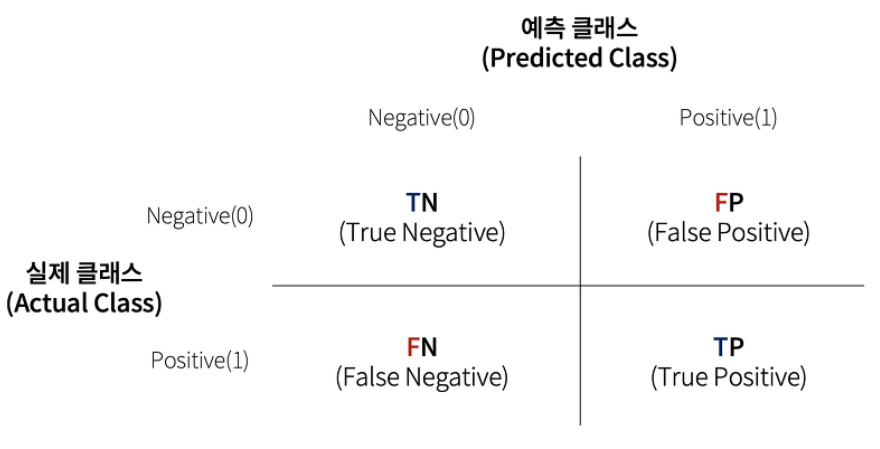

TN, FP, FN, TP는 예측 클래스와 실제 클래스의 Positive 결정 값(값 1)과 Negative 결정 값(값 0)의 결합에 따라 결정된다. 

* TN : 예측값을 Negative(값 0)로 예측했고 실제 값 역시 Negative(값 0).
* FP : 예측값을 Positive(값 1)로 예측했으나 실제 값은 Negative(값 0).
* FN : 예측값을 Negative(값 0)로 예측했으나 실제 값은 Positive(값 1).
* TP : 예측값을 Positive(값 1)로 예측했고 실제 값 역시 Positive(값 1).

    from sklearn.metrics import confusion_matrix

In [6]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, fakepred)

array([[405,   0],
       [ 45,   0]])

TN=405, FP=0, FN=45, TP=0

450건 데이터 중 무조건 Negative 0으로 예측해서 True가 된 결과 405건, FP는 Positive 1로 예측한 건수가 없으므로 0건, FN은 Positive 1인 건수 45건을 Negative로 예측해서 False가 된 결과 45건, TP는 Positive 1로 예측한 건수가 없으므로 0건 이다.

TP, TN, FP, FN 값들을 조합하여 Classifier의 성능을 측정할 수 있는 주요 지표인 정확도(Accuracy), 정밀도(Precision), 재현율(Recall) 값을 알 수 있다.

* 정확도 = 예측 결과와 실제 값이 동일한 건수 / 전체 데이터 수 (= (TN+TP)/(TN+TP+FN+FP))

일반적으로 이러한 불균형한 레이블 클래스를 가지는 이진 분류 모델에서는 많은 데이터 중에서 중점적으로 찾아야하는 매우 적은 수의 결과값에 Positive를 설정해 1값을 부여하고, 그렇지 않은 경우 Negative로 0값을 부여하는 경우가 많다. 불균형한 이진 분류 데이터 세트에서는 Positive 데이터 건수가 매우 작기 때문에 데이터에 기반한 ML 알고리즘은 Positive보다는 Negative로 예측 정확도가 높아지는 경향이 발생한다.

# 정밀도와 재현율

정밀도와 재현율은 Positive 데이터 세트의 예측 성능에 좀 더 초점을 맞춘 평가 지표이다.

위에서 만든 MyFakeClassifier는 Positive로 예측한 TP 값이 하나도 없기 때문에 정밀도와 재현율 값이 모두 0이다.

* 정밀도 = TP / (FP+TP)
* 재현율 = TP / (FN+TP)


**정밀도는 예측을 Positive로 한 대상 중에서 실제 값이 Positive로 일치한 데이터의 비율**

공식의 분모인 FP+TP는 **예측을 Positive로** 한 모든 데이터 건수이며, 공식의 분자인 TP는 예측과 실제 값이 Positive로 일치한 데이터 건수이다. Positive 예측 성능을 더욱 정밀하게 측정하기 위한 평가 지표로 양성 예측도라고 한다.

**재현율은 실제 값이 Positive인 대상 중에서 예측과 실제 값이 Positive로 일치한 데이터의 비율**

공식의 분모인 FN+TP는 **실제 값이 Positive인** 모든 데이터의 건수이며, 공식의 분자인 TP는 예측과 실제 값이 Positive로 일치한 데이터 건수이다. 민감도(Sensitivity) 또는 TPR(True Positive Rate)라고도 불린다.

정밀도와 재현율 지표 중에 이진 분류 모델의 업무 특성에 따라서 특정 평가 지표가 더 중요한 지표로 간주될 수 있다. **재현율이 중요 지표인 경우는 실제 Positive 양성 데이터를 Negative로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우이다.**

예) 암 판단 모델 - 재현율이 훨씬 중요한 경우

이유 : 실제 Positive인 암 환자를 Positive 양성이 아닌 Negative 음성으로 잘못 판단했을 경우 오류의 대가가 매우 심각하기 때문이다. 또한, 실제 Negative인 건강한 환자를 Positive로 예측한 경우 재검사 비용이 소모된다. ( + 보험 사기와 같은 금융 사기 적발 모델)

**정밀도가 더 중요한 지표인 경우**

예) 스팸메일 여부를 판단하는 모델

실제 Positive인 스팸 메일을 Negative인 일반 메일로 분류하더라도 사용자가 불편함을 느끼는 정도이지만, 실제 Negative인 일반 메일을 Positive인 스팸 메일로 분류할 경우 메일을 아예 받지 못하는 경우가 발생.

* 재현율이 상대적으로 더 중요한 지표인 경우 : 실제 Positive 양성인 데이터 예측을 Negative로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우

* 정밀도가 상대적으로 더 중요한 지표인 경우 : 실제 Negative 음성인 데이터 예측을 Positive로 잘못 판단하게 되면 업무상 큰 영향을 발생하는 경우

가장 좋은 성능 평가는 재현율과 정밀도 모두 높은 수치를 얻는 것이다. 반면에 둘 중 어느 한 평가 지표만 매우 높고, 다른 수치는 매우 낮은 결과를 나타내는 경우는 바람직하지 않다.

        from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix



In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
    precision = precision_score(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    recall = recall_score(y_test, pred)
    confusion = confusion_matrix(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율 {2:.4f}'.format(accuracy, precision, recall))

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# 원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할
titanic_df = pd.read_csv('./titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=11)
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차 행렬
[[104  14]
 [ 13  48]]
정확도 : 0.8492, 정밀도 : 0.7742, 재현율 0.7869


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


# 정밀도/재현율 트레이드오프

분류하려는 업무상의 특성상 정밀도 또는 재현율이 특별히 강조돼야 할 경우 분류의 결정 임곗값(Threshold)을 조정해 정밀도 또는 재현율의 수치를 높일 수 있다. 하지만 정밀도와 재현율은 상호 보완적인 평가 지표이기 때문에 어느 한쪽을 강제로 높이면 다른 한쪽은 떨어지기 쉽다. 이를 정밀도/재현율의 트레이드오프(Trade-off)라고 부른다.

사이킷런의 분류 알고리즘은 예측 데이터가 특정 레이블(Label, 결정 클래스 값)에 속하는지 계산하기 위해 먼저 개별 레이블별로 결정 확률을 구한다. 그리고 예측 확률이 큰 레이블값으로 예측학게 된다. 일반적으로 이진 분류에서는 이 임계값을 0.5, 50%로 정하고 이 기준 값보다 확률이 크면 Positivem, 작으면 Negative로 결정.

<hr/><br/>

사이킷런은 개별 데이터별로 예측 확률을 반환하는 메서드인 predict_proba()를 제공.

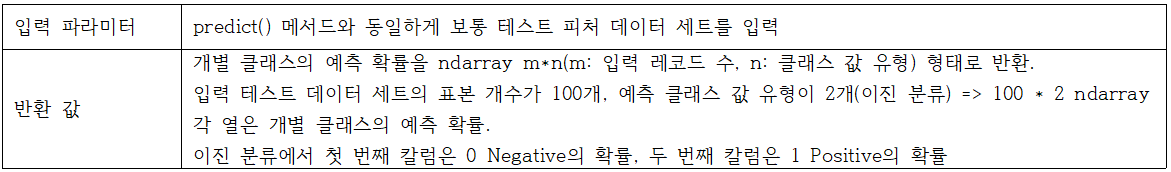

In [9]:
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print('pred_proba 반환값 shape :',pred_proba.shape)
print('pred_proba array에서 앞 3개만 샘플로 추출\n')
print(pred_proba[:3])

# 예측 확률 array와 예측 결과값 array를 병합(concatenate)해 예측 확률과 결과값을 한눈에 확인
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1, 1)], axis=1)
print('두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측\n', pred_proba_result[:3])

pred_proba 반환값 shape : (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출

[[0.46191519 0.53808481]
 [0.878675   0.121325  ]
 [0.87716185 0.12283815]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측
 [[0.46191519 0.53808481 1.        ]
 [0.878675   0.121325   0.        ]
 [0.87716185 0.12283815 0.        ]]


반환 결과인 ndarray는 0과 1에 대한 확률을 나타내므로 첫 번째 컬럼과 두 번째 컬럼을 더하면 1이 된다. 두 개의 칼럼 중에서 더 큰 확률 값으로 predict() 메서드가 최종 예측을 하고 있다.

#### 사이킷런의 정밀도/재현율 트레이드오프 방식

predict()는 predict_proba() 메서드가 반환하는 확률 값을 가진 ndarray에서 정해진 임계값을 만족하는 ndarray의 칼럼 위치를 최종 예측 클래스로 결정한다.

이러한 구현을 위해 사이킷런의 Binarizer 클래스를 이용한다.

In [10]:
from sklearn.preprocessing import Binarizer

X = [[1, -1, 2],
     [2, 0, 0],
     [0, 1.1, 1.2]]

# X의 개별 원소들이 threshold값보다 같거나 작으면 0, 크면 1을 반환
binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


Binarizer를 이용해 pred_proba 객체 변수에 분류 결정 임계값(threshold)을 0.4로 지정한 Binarizer 클래스를 적용하여 최종 예측값을 구하고, 이 최종 예측값에 대해 get_clf_eval() 함수를 적용해 평가 지표를 출력해보자.

In [11]:
from sklearn.preprocessing import Binarizer

# Binarizer의 threshold 설정값. 분류 결정 임계값(default=0.5)
custom_threshold = 0.4

# predict_proba() 반환값의 두 번째 칼럼, 즉 positive 클래스 칼럼 하나만 추출해 Binarizer를 적용
pred_proba_1 = pred_proba[:, 1].reshape(-1, 1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)
get_clf_eval(y_test, custom_predict)

# 오차 행렬
# [[104  14]
#  [ 13  48]]
# 정확도 : 0.8492, 정밀도 : 0.7742, 재현율 0.7869

오차 행렬
[[98 20]
 [10 51]]
정확도 : 0.8324, 정밀도 : 0.7183, 재현율 0.8361


임계값을 낮추니 재현율이 올라가고 정밀도가 떨어졌다. 분류 결정 임계값은 Positive 예측값을 결정하는 확률의 기준이 된다. 확률이 0.5가 아닌 0.4부터 Positive로 예측하기 때문에 True 값이 더 많아졌다.

In [12]:
# 임계값 0.4 ~ 0.6까지 0.05씩 증가시키면서 평가지표 조사
thresholds = [0.40, 0.45, 0.50, 0.55, 0.60]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    # thresholds list 객체 내의 값을 차례로 iteration 하면서 Evaluation 수행
    for th in thresholds:
        binarizer = Binarizer(threshold=th).fit(pred_proba_c1)
        predict = binarizer.transform(pred_proba_c1)
        print('임계값 :',th)
        get_clf_eval(y_test, predict)

get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임계값 : 0.4
오차 행렬
[[98 20]
 [10 51]]
정확도 : 0.8324, 정밀도 : 0.7183, 재현율 0.8361
임계값 : 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도 : 0.8492, 정밀도 : 0.7656, 재현율 0.8033
임계값 : 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도 : 0.8492, 정밀도 : 0.7742, 재현율 0.7869
임계값 : 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도 : 0.8659, 정밀도 : 0.8364, 재현율 0.7541
임계값 : 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도 : 0.8771, 정밀도 : 0.8824, 재현율 0.7377


임계값 변화에 따른 평가 지표 값을 알아보았다. 사이킷런은 이와 유사한 precision_recall_curve() API를 제공.

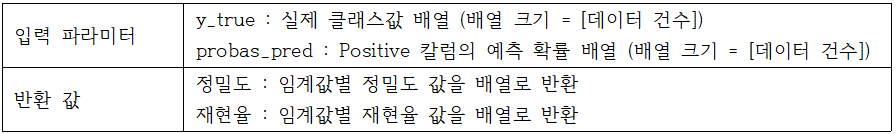

precision_recall_curve()는 일반적으로 0.11 ~ 0.95 정도의 임계값을 담은 넘파이 ndarray와 이 임계값에 해당하는 정밀도 및 재현율 값을 담은 넘파이 ndarray를 반환한다.

In [13]:
from sklearn.metrics import precision_recall_curve

# 레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

# 실제값 데이터 세트와 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임계값 배열의 Shape :', thresholds.shape)

# 반환된 임계값 배열 로우가 147건이므로 샘플로 10건만 추출하되, 임계값을 15 Step으로 추출
thr_index = np.arange(0, thresholds.shape[0], 15)
print('샘플 추출을 위한 임계값 배열의 index 10개 :',thr_index)
print('샘플용 10개의 임계값 :', np.round(thresholds[thr_index], 2))

# 15 step 단위로 추출된 임계값에 따른 정밀도와 재현율 값
print('샘플 임계값별 정밀도 :', np.round(precisions[thr_index], 3))
print('샘플 임계값별 재현율 :', np.round(recalls[thr_index], 3))

반환된 분류 결정 임계값 배열의 Shape : (143,)
샘플 추출을 위한 임계값 배열의 index 10개 : [  0  15  30  45  60  75  90 105 120 135]
샘플용 10개의 임계값 : [0.1  0.12 0.14 0.19 0.28 0.4  0.56 0.67 0.82 0.95]
샘플 임계값별 정밀도 : [0.389 0.44  0.466 0.539 0.647 0.729 0.836 0.949 0.958 1.   ]
샘플 임계값별 재현율 : [1.    0.967 0.902 0.902 0.902 0.836 0.754 0.607 0.377 0.148]


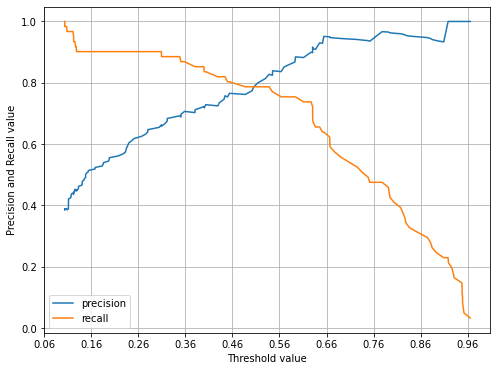

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)

    # X 축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8, 6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='-', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')

    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))

    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()
    plt.show()

precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])

추출된 임계값 샘플 10개에 해당하는 정밀도 값과 재현율 값을 살펴보면 임계값이 증가할수록 정밀도 값은 동시에 높아지고 재현율 값은 낮아짐을 알 수 있다.

# 정밀도와 재현율의 맹점

Positive 예측의 임계값을 변경함에 따라 정밀도와 재현율의 수치가 변경된다. 임계값의 이러한 변경은 업무 환경에 맞게 두 개의 수치를 상호 보완할 수 있는 수준에서 적용돼야 한다. 그렇지 않고 단순히 하나의 성능 지표 수치를 높이기 위한 수단으로 사용해서는 안된다.

<br/>

#### 정밀도가 100%가 되는 방법

확실한 기준이 되는 경우만 Positive로 예측하고 나머지는 Negative로 예측한다. 예를 들어 환자가 80세 이상이고 비만이며 이전에 암 진단을 받았고 암 세포의 크기가 상위 0.1% 이상이면 무조건 Positive, 다른 경우는 Negative로 예측.

정밀도 = TP/(TP+FP) 이므로, 전체 환자 1000명 중 확실한 Positive 징후를 가진 환자가 1명이라고 할때 이 한명만 Positive로 예측하고 나머지는 모두 Negative 예측하더라도 FP는 0, TP는 1이 되므로 정밀도는 100%가 된다.

<br/>

#### 재현율이 100%가 되는 방법

재현율 = TP/(TP+FN)이므로, 모든 환자를 Positive로 예측하면 1000명 중 양성인 사람이 30명 정도라도 TN이 수치에 포함되지 않고 FN은 아예 0이므로 30/(30+0)으로 100%가 된다.

이렇게 숫자 놀음에 불과한 방법으로 한 쪽 수치를 극단적으로 수치 조작이 가능하다. 따라서 정밀도 또는 재현율 중 하나만 스코어가 좋고 다른 하나는 스코어가 나쁜 분류는 성능이 좋지 않은 분류로 간주할 수 있다. 그러므로 정밀도와 재현율의 수치가 적절하게 조합하여 분류의 종합적인 성능 평가에 사용될 수 있는 평가 지표가 필요하다.

# F1 스코어

F1 스코어(Score)는 정밀도와 재현율을 결합한 지표이다. F1 스코어는 정밀도와 재현율이 어느 한 쪽으로 치우치지 않는 수치를 나타낼 때 상대적으로 높은 값을 가진다.

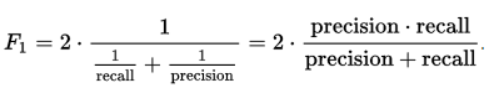

예를 들어, A 예측 모델의 경우 정밀도가 0.9, 재현율이 0.1로 극단적인 차이가 나고, B 예측 모델은 정밀도 0.5, 재현율 0.5로 정밀도와 재현율이 큰 차이가 없다고 하자. A 예측 모델의 F1 스코어는 0.18, B 예측 모델의 F1 스코어는 0.5로, B 예측 모델이 A 모델에 비해 매우 우수한 F1 스코어를 가지게 된다.

        from sklearn.metrics import f1_score

In [15]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred)
print('F1 스코어 : {0:.4f}'.format(f1))

F1 스코어 : 0.7805


In [16]:
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    # F1 스코어
    f1 = f1_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    # f1 score print 추가
    print('정확도 : {0:.4f} 정밀도 {1:.4f} 재현율 {2:.4f} F1 {3:.4f}\n'.format(accuracy, precision, recall, f1))

thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임계값 : 0.4
오차 행렬
[[98 20]
 [10 51]]
정확도 : 0.8324 정밀도 0.7183 재현율 0.8361 F1 0.7727

임계값 : 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도 : 0.8492 정밀도 0.7656 재현율 0.8033 F1 0.7840

임계값 : 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도 : 0.8492 정밀도 0.7742 재현율 0.7869 F1 0.7805

임계값 : 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도 : 0.8659 정밀도 0.8364 재현율 0.7541 F1 0.7931

임계값 : 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도 : 0.8771 정밀도 0.8824 재현율 0.7377 F1 0.8036



F1 스코어는 임계값이 0.6일 때 가장 좋은 값을 보여준다. 하지만 재현율이 크게 감소하고 있어 주의해야한다.

# ROC 곡선과 AUC

ROC 곡선과 이에 기반한 AUC 스코어는 이진 분류의 예측 성능 측정에 중요하게 사용되는 지표이다. ROC 곡선(Receiver Operation Characteristic Curve)은 수신자 판단 곡선으로 불린다. 일반적으로 의학 분야에서 많이 사용되지만, 머신러닝 이진 분류 모델의 예측 성능을 판단하는 중요한 평가 지표이기도 하다. ROC 곡선은 FPR(False Positive Rate)이 변할 때 TPR(True Positive Rate)이 어떻게 변하는지 나타내는 곡선이다. FPR을 X축으로, TPR을 Y축으로 잡으면 FPR의 변화에 따른 TPR의 변화가 곡선 형태로 나타낸다.

TPR은 재현율(TP/(FN+TP))을 나타내며, 민감도로도 불린다. 민감도에 대응하는 지표 = TNR(True Negative Rate)이라고 불리는 특이성(Specificity)이 있다.

* 민감도(TPR)는 실제값 Positive(양성)가 정확히 예측되어야 하는 수준을 나타낸다(질병이 있는 사람은 질병이 있는 것으로 양성 판정)

* 특이성(TNR)은 실제값 Negative(음성)가 정확히 예측되어야 하는 수준을 나타낸다(질병이 없는 건강한 사람은 질병이 없는 것으로 음성 판정)

TNR인 특이성은 TN / (FP+TN)이다. 그리고 ROC 곡선의 X 축인 FPR은 FP/(FP+TN)이므로 1-TNR(1-특이성)으로 표현된다.

ROC 곡선은 FPR을 0부터 1까지 변경(임계값 변경)하면서 TPR의 변화값을 구한다. 분류 결정 임계값은 Positive 예측값을 결정하는 확률의 기준이기 때문에 FPR을 0으로 만들려면 임계값을 1로 지정한다. 임계값을 1로 지정하면 Positive 예측 깁준이 매우 높기 때문에 분류기(Classifier)가 임계값보다 높은 확률을 가진 데이터를 Positive로 예측할 수 없기 때문이다. 그래서 아예 Positive로 예측하지 않기 때문에 FP 값이 0이 되므로 FPR은 0이 된다.

반대로 FPR을 1로 만드는 방법은 TN을 0으로 만들면 된다. TN을 0으로 만들려면 분류 결정 임계값을 0으로 지정한다. 그러면 분류기의 Positive 확률 기준이 매우 낮아져 모두 Positive로 예측하게 된다. 그러면 Negative 예측이 없기 때문에 TN이 0이 되고 FPR은 1이 된다.

이렇게 임계값을 1부터 0까지 변화시키면서 FPR을 구하고 이 FPR 변화에 따른 TPR 값을 구하는 것이 ROC 곡선이다.

사이킷런은 ROC 곡선을 구하기 위해 roc_curve() API를 제공한다.

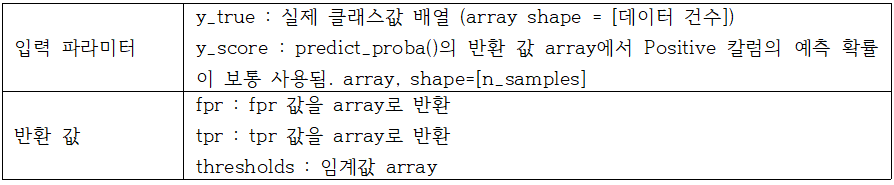

In [17]:
from sklearn.metrics import roc_curve

# 레이블 값이 1일때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)
# 반환된 임계값 배열에서 샘플로 데이터를 추출하되, 임계값을 5 step으로 추출
# thresholds[0]은 max(예측 확률)+1로 임의 설정됨. 이를 제외하기 위해 np.arange는 1부터 시작
thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임계값 배열의 index: ', thr_index)
print('샘플 index로 추출한 임계값: ', np.round(thresholds[thr_index], 3))

# 5 Step 단위로 추출된 임계값에 따른 FPR< TPR 값
print('샘플 임계값별 FPR: ', np.round(fprs[thr_index], 3))
print('샘플 임계값별 TPR: ', np.round(tprs[thr_index], 3))

샘플 추출을 위한 임계값 배열의 index:  [ 1  6 11 16 21 26 31 36 41 46 51]
샘플 index로 추출한 임계값:  [0.965 0.654 0.63  0.563 0.454 0.4   0.348 0.148 0.125 0.112 0.108]
샘플 임계값별 FPR:  [0.    0.017 0.034 0.076 0.127 0.169 0.203 0.466 0.585 0.686 0.797]
샘플 임계값별 TPR:  [0.033 0.639 0.721 0.754 0.803 0.836 0.885 0.902 0.934 0.967 0.984]


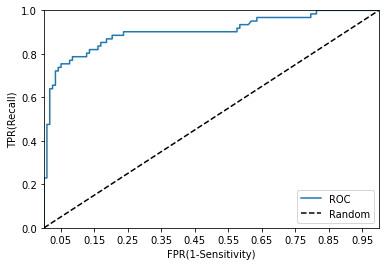

In [18]:
def roc_curve_plot(y_test, pred_proba_c1):
    # 임계값에 따른 FPR, TPR 값을 반환받음
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    # ROC 곡선을 그래프 곡선으로 그림
    plt.plot(fprs, tprs, label='ROC')
    # 가운데 대각선 직선을 그림
    plt.plot([0, 1], [0, 1], 'k--', label='Random')

    # FPR X축의 Scale을 0.1 단위로 변경, X, Y축 명 설정 등
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('FPR(1-Sensitivity)')
    plt.ylabel('TPR(Recall)')
    plt.legend()

roc_curve_plot(y_test, pred_proba[:, 1])

그래프를 보면 임계값이 1에 가까운 값에서 점점 작아지면서 FPR이 점점 커진다. 그리고 FPR이 조금씩 커질 때 TPR이 급격히 커짐을 알 수 있다.

일반적으로 ROC 곡선 자체는 FPR과 TPR의 변화 값을 보는데 이용하며 분류의 성능 지표로 사용되는 것은 ROC 곡선 면적에 기반한 AUC 값으로 결정한다. AUC(Area Under Curve) 값은 ROC 곡선 밑의 면적을 구한 것으로서 일반적으로 1에 가까울수록 좋은 수치이다. AUC 수치가 커지려면 FPR이 작은 상태에서 얼마나 큰 TPR을 얻을 수 있느냐가 관건이다.

가운데 직선에서 멀어지고 왼쪽 상단 모서리 쪽으로 가파르게 곡선이 이동할수록 직사각형에 가까운 곡선이 되며 면적이 1에 가까워진다. 가운데 대각선 직선은 랜덤 수준의(동전 던지기 수준) 이진 분류 AUC 값으로 0.5이다. 따라서 보통의 분류는 0.5이상의 AUC 값을 가진다.

In [19]:
from sklearn.metrics import roc_auc_score

pred_proba = lr_clf.predict_proba(X_test)[:, 1]
roc_score = roc_auc_score(y_test, pred_proba)
print('ROC AUC 값 : {0:.4f}'.format(roc_score))

ROC AUC 값 : 0.9024


In [20]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    # ROC AUC
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC AUC 추가
    print('정확도 : {0:.4f} 정밀도 {1:.4f} 재현율 {2:.4f} F1 {3:.4f} AUC {4:.4f}\n'.format(accuracy, precision, recall, f1, roc_auc))

get_clf_eval(y_test, pred, pred_proba)

오차 행렬
[[104  14]
 [ 13  48]]
정확도 : 0.8492 정밀도 0.7742 재현율 0.7869 F1 0.7805 AUC 0.9024



# 피마 인디언 당뇨병 예측

피마 인디언 당뇨병(Pima Indian Diabetes) 데이터 세트를 이용해 당뇨병 여부를 판단하는 머신러닝 예측 모델을 수립하고, 평가 지표 적용.

피마 인디언 당뇨병 데이터 세트 : https://www.kaggle.com/uciml/pima-indians-diabetes-database

**피마 인디언 당뇨병 데이터 세트 구성**

* Pregnancies : 임신 횟수
* Glucose : 포도당 부하 검사 수치
* BloodPressure : 혈압(mm Hg)
* SkinThickness : 팔 삼두근 뒤쪽의 피하지방 측정값(mm)
* Insulin : 혈청 인슐린(mu U/ml)
* BMI : 체질량지수(체중(kg)/(키(m))^2)
* DiabetesPedigreeFunction : 당뇨 검사 수치
* Age : 나이
* Outcome : 클래스 결정 값(0 또는 1)

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

diabetes_data = pd.read_csv('./diabetes.csv')
print(diabetes_data['Outcome'].value_counts())
diabetes_data.head(3)

0    500
1    268
Name: Outcome, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


전체 768개의 데이터 중에서 Negative 값 0이 500개, Positive 값 1이 268개로 Negative가 상대적으로 많다.

In [22]:
# feature 타입과 Null 개수 확인
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Null 값은 없으며 피처 타입은 모두 숫자형이다. 임신 횟수, 나이와 같은 숫자형 피처와 당뇨 검사 수치 피처로 구성된 특징으로 볼 때 별도의 피처 인코딩은 필요하지 않아 보인다.

이제 로지스틱 회귀를 이용하여 예측 모델을 생성하자.


* stratify: default=None. classification을 다룰 때 매우 중요한 옵션값이다. stratify 값을 target으로 지정해주면 각각의 class 비율(ratio)을 train / validation에 유지해준다. (한 쪽에 쏠려서 분배되는 것을 방지합니다) 만약 이 옵션을 지정해 주지 않고 classification 문제를 다룬다면, 성능의 차이가 많이 날 수 있다.

In [23]:
# 피처 데이터 세트 X, 레이블 데이터 세트 y를 추출
# 가장 끝 Outcome 칼럼이 레이블 값(클래스 결정 값)이다.
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=156, stratify=y)

# 로지스틱 회귀로 학습, 예측 및 평가 수행
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, pred, pred_proba)

오차 행렬
[[88 12]
 [23 31]]
정확도 : 0.7727 정밀도 0.7209 재현율 0.5741 F1 0.6392 AUC 0.7919



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


예측 정확도가 77.27%, 재현율은 57.41%로 측정되었다. 전체 데이터의 65%가 Negative이므로 정확도보다는 재현율 성능에 조금 더 초점을 맞춰보자. 먼저 정밀도 재현율 곡선을 보고 임계값별 정밀도와 재현율 값의 변화를 확인하자.

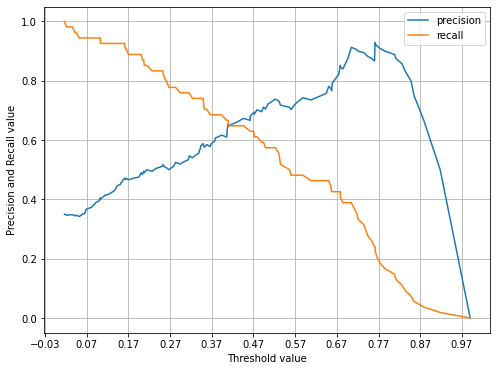

In [24]:
pred_proba_c1 = lr_clf.predict_proba(X_test)[:, 1]
precision_recall_curve_plot(y_test, pred_proba_c1)

재현율 곡선을 보면 임계값 0.42정도로 낮추면 정밀도와 재현율이 어느 정도 균형을 맞출 수 있을 것 같다. 하지만 두 개의 지표 모두 0.7이 안되는 낮은 값이다.

원본 데이터 DataFrame의 describe()를 호출하여 피처값의 분포도를 확인해보자.

In [25]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


위 결과를 보면 min() 값이 0으로 되어있는 피처가 상당히 많은데, Glucose 피처를 보면 포도당 수치인데 min 값이 0인 것이 말이 되지 않는다. 

(array([  5.,   0.,   4.,  32., 156., 211., 163.,  95.,  56.,  46.]),
 array([  0. ,  19.9,  39.8,  59.7,  79.6,  99.5, 119.4, 139.3, 159.2,
        179.1, 199. ]),
 <a list of 10 Patch objects>)

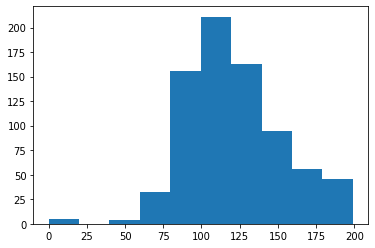

In [26]:
plt.hist(diabetes_data['Glucose'], bins=10)

위 Glucose 피처의 히스토그램을 확인해보면 0 값이 일정 수준 존재하는 것을 알 수 있다. min() 값이 0으로 되어있는 피처에 대해 0 값의 건수 및 전체 데이터 건수 대비 몇 퍼센트 비율로 존재하는지 확인해봐야한다.

In [27]:
# 0 값을 검사할 피처명 리스트
# Pregnencies는 출산 횟수이므로 제외
zero_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# 전체 데이터 건수
total_count = diabetes_data['Glucose'].count()

# 피처별로 반복하면서 데이터 값이 0인 데이터 건수 출력. 퍼센트 계산
for f in zero_features:
    zero_count = diabetes_data[diabetes_data[f] == 0][f].count()
    print('{0} 0 건수는 {1}, 퍼센트는 {2:.2f}%'.format(f, zero_count, 100 * zero_count/total_count))

Glucose 0 건수는 5, 퍼센트는 0.65%
BloodPressure 0 건수는 35, 퍼센트는 4.56%
SkinThickness 0 건수는 227, 퍼센트는 29.56%
Insulin 0 건수는 374, 퍼센트는 48.70%
BMI 0 건수는 11, 퍼센트는 1.43%


SkinThickness와 Insulin 의 0 값은 각각 전체의 29.56%, 48.7%로 아주 많다. 전체 데이터 건수가 많지 않기 때문에 이들 데이터를 일괄적으로 삭제하는 것은 좋지 않다. 위 피처의 0 값을 평균값으로 대체해보자.

In [28]:
# zero_features 리스트 내부에 저장된 개별 피처들에 대해서 0 값을 평균 값으로 대체
mean_zero_features = diabetes_data[zero_features].mean()
print(mean_zero_features)
diabetes_data[zero_features] = diabetes_data[zero_features].replace(0, mean_zero_features)
diabetes_data.describe

Glucose          120.894531
BloodPressure     69.105469
SkinThickness     20.536458
Insulin           79.799479
BMI               31.992578
dtype: float64


<bound method NDFrame.describe of      Pregnancies  Glucose  ...  Age  Outcome
0              6    148.0  ...   50        1
1              1     85.0  ...   31        0
2              8    183.0  ...   32        1
3              1     89.0  ...   21        0
4              0    137.0  ...   33        1
..           ...      ...  ...  ...      ...
763           10    101.0  ...   63        0
764            2    122.0  ...   27        0
765            5    121.0  ...   30        0
766            1    126.0  ...   47        1
767            1     93.0  ...   23        0

[768 rows x 9 columns]>

0 값을 평균값으로 대체한 데이터 세트에 대해 피처 스케일링을 적용해 변환하자. 로지스틱 회귀의 경우 일반적으로 숫자 데이터에 스케일링을 적용하는 것이 좋다. 이후 다시 학습/테스트 데이터 세트로 나누고 로지스틱 회귀를 적용해 성능 평가 지표를 확인하자.

In [29]:
from sklearn.preprocessing import StandardScaler

X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

# StandardScaler 클래스를 이용해 피처 데이터 세트에 일괄적으로 스케일링 적용
scaler = StandardScaler( )
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 156, stratify=y)

# 로지스틱 회귀로 학습, 예측 및 평가 수행. 
lr_clf = LogisticRegression()
lr_clf.fit(X_train , y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test , pred, pred_proba)

오차 행렬
[[90 10]
 [21 33]]
정확도 : 0.7987 정밀도 0.7674 재현율 0.6111 F1 0.6804 AUC 0.8433



데이터 변환과 스케일링을 통해 성능 수치가 일정 수준 개선되었다. 하지만 재현율 수치는 개선이 필요해보인다. 분류 결정 임계값을 변화시키면서 재현율 값의 성능 수치가 어느 정도나 개선되는지 확인해보자. 임계값을 0.3에서 0.5까지 0.03씩 변화시키며 재현율과 다른 평가 지표의 값 변화를 출력.

In [30]:
from sklearn.preprocessing import Binarizer

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임계값 :',custom_threshold)
        get_clf_eval(y_test, custom_predict, pred_proba_c1)
        print('===============================================')

In [31]:
thresholds = [0.3, 0.33, 0.36, 0.39, 0.42, 0.45, 0.48, 0.5]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임계값 : 0.3
오차 행렬
[[67 33]
 [11 43]]
정확도 : 0.7143 정밀도 0.5658 재현율 0.7963 F1 0.6615 AUC 0.8433

임계값 : 0.33
오차 행렬
[[72 28]
 [12 42]]
정확도 : 0.7403 정밀도 0.6000 재현율 0.7778 F1 0.6774 AUC 0.8433

임계값 : 0.36
오차 행렬
[[76 24]
 [15 39]]
정확도 : 0.7468 정밀도 0.6190 재현율 0.7222 F1 0.6667 AUC 0.8433

임계값 : 0.39
오차 행렬
[[78 22]
 [16 38]]
정확도 : 0.7532 정밀도 0.6333 재현율 0.7037 F1 0.6667 AUC 0.8433

임계값 : 0.42
오차 행렬
[[84 16]
 [18 36]]
정확도 : 0.7792 정밀도 0.6923 재현율 0.6667 F1 0.6792 AUC 0.8433

임계값 : 0.45
오차 행렬
[[85 15]
 [18 36]]
정확도 : 0.7857 정밀도 0.7059 재현율 0.6667 F1 0.6857 AUC 0.8433

임계값 : 0.48
오차 행렬
[[88 12]
 [19 35]]
정확도 : 0.7987 정밀도 0.7447 재현율 0.6481 F1 0.6931 AUC 0.8433

임계값 : 0.5
오차 행렬
[[90 10]
 [21 33]]
정확도 : 0.7987 정밀도 0.7674 재현율 0.6111 F1 0.6804 AUC 0.8433



임계값 0.48이 전체적인 성능 평가 지표를 유지하면서 재현율을 약간 향상시키는 좋은 임계값으로 보인다. 임계값 0.48일 경우 정확도 : 0.7987 정밀도 0.7447 재현율 0.6481 F1 0.6931 AUC 0.8433이다.

로지스틱 회귀 모델을 이용하여 임계값을 0.48로 낮춘 상태에서 다시 예측해보자. 사이킷런의 predict() 메서드는 임계값을 변환할 수 없으므로 별도 로직으로 구현해야 한다. Binarizer 클래스를 이용해 predict_proba()로 추출한 예측 결과 확률을 변환하여 변경된 임계값에 따른 예측 클래스 값을 구해보자.

In [32]:
# 임계값 0.48로 설정한 Binarizer 생성
binarizer = Binarizer(threshold=0.48)

# 위에서 구한 lr_clf의 predict_proba() 예측 확률 array에서 1에 해당하는 칼럼값을 Binarizer 변환
pred_048 = binarizer.fit_transform(pred_proba[:, 1].reshape(-1, 1))
get_clf_eval(y_test, pred_048, pred_proba[:, 1])

오차 행렬
[[88 12]
 [19 35]]
정확도 : 0.7987 정밀도 0.7447 재현율 0.6481 F1 0.6931 AUC 0.8433

